## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [1]:
import numpy as np
from numba import vectorize, int64, float32, int16, cuda

@vectorize([float32(float32)], target='parallel', fastmath=True) 
#to use cuda target must become cuda. Since emulator has a bug we use parallel
def vec_log(x):
    c =  np.log(x)
    return c

A = np.float32([2,5,10,3,8])

a = vec_log(A)
 
print('Log:',a)

Log: [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]


In [2]:
@vectorize([float32(float32)], target='parallel', fastmath=True) 
#to use cuda target must become cuda. Since emulator has a bug we use parallel
def vec_exp(x):
    c =  np.exp(x)
    return c

A = np.float32([2,5,10,3,8])

a = vec_exp(A)
 
print('Exp:',a)

Exp: [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

In [3]:
@vectorize([float32(float32)], target='parallel', fastmath=True)
def gaussian_pdf(x):
    sigma = 1
    mean  = 1
    return 1 / (np.sqrt(2 * np.pi) * sigma) * np.exp(-((x-mean)/sigma)**2 / 2)

In [4]:
size = 100000
xs = np.linspace(-3, 3, size, dtype='float32')

gaussian_pdf(xs)

array([0.00013383, 0.00013386, 0.00013389, ..., 0.05400392, 0.05399745,
       0.05399097], dtype=float32)

## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

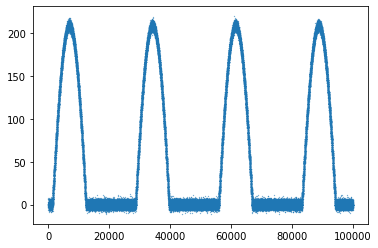

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)

plt.plot(data,'.',markersize=0.5)

In [6]:
@vectorize([int16(int16,int16)], target='parallel', fastmath=True)
def zero_suppression(x,threshold):
    if x < threshold:
        return 0
    else:
        return x

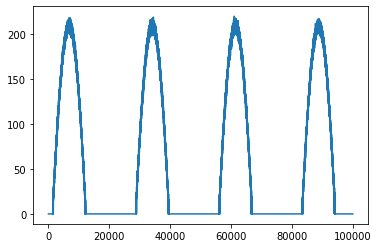

In [7]:
data_suppressed = zero_suppression(data,15)
plt.plot(data_suppressed)

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [8]:
import math

In [9]:
n = 3

X = np.random.rand(n,n).astype('float32')
Y = np.random.rand(n,n).astype('float32')
result = np.zeros((n,n), dtype='float32')

In [10]:
@cuda.jit
def sigmoid_kernel(x,y,result,alpha,c):
    
    row, col = cuda.grid(2)
    
    if row < result.shape[0] and col < result.shape[1]:
        tmp = 0.
        for k in range(x.shape[0]):
            tmp += x[k, row] * y[k, col]
            
        result[row, col] = math.tanh(alpha * tmp + c)
        
# Now start the kernel
sigmoid_kernel[(1,1), (3,3)](X, Y, result, 1., 1.)

## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [11]:
from numba import cuda

# CUDA kernel
@cuda.jit
def cos_kernel_3D(io_array):
    row, col, l = cuda.grid(3)
    if row < io_array.shape[0] and col < io_array.shape[1] and l < io_array.shape[2]:
        io_array[row][col][l] *= math.cos(io_array[row][col][l]) # do the computation

In [12]:
x = np.random.normal(size=(256,256,256))

In [13]:
threadsperblock = (16, 16)
blockspergrid_x = int(math.ceil(x.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(x.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

In [14]:
cos_kernel_3D[blockspergrid, threadsperblock](x)
print(x)

[[[-0.54237815  0.00384064 -1.62310526 ...  0.64895065  1.20436231
   -1.70245353]
  [ 0.52184322  0.25540633  0.61505861 ... -0.64095605  1.06049933
   -0.28402962]
  [-0.46324723 -0.40304838 -0.42504755 ... -1.21017416  1.37884919
    0.70931793]
  ...
  [-0.16431692 -0.62873397 -1.32522678 ...  0.8560352   0.97449939
   -1.60746425]
  [ 1.42732941  0.46233102 -2.07180218 ...  0.93192629 -0.26755984
    0.27378388]
  [ 0.18872093  2.58601173  0.14817903 ...  0.35372417  1.11901678
   -1.58571692]]

 [[ 0.44700083  1.37303519  0.5847545  ... -1.03997644  0.93636579
   -0.73215974]
  [ 0.43679387  0.31228423  2.15990765 ... -0.24087921 -0.32800058
   -0.32902079]
  [-0.50442294  0.03034899  0.49452128 ...  0.13163444 -0.21934702
    0.8020564 ]
  ...
  [ 0.14005966 -0.80698049 -0.31328389 ...  0.06680705  1.60542319
    0.22255824]
  [-0.13109333 -0.8087281   1.36245415 ... -1.49857818 -1.04544295
   -0.5484201 ]
  [-0.0473337  -2.90005392 -0.03081727 ...  1.03259131  0.44284361
    0.

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [15]:
from __future__ import division
from numba import cuda
import numpy
import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = np.random.randint(100, size=(24,12))
B = np.random.randint(100, size=(12,22))

# Configure the blocks
threadsperblock = (24, 22)
blockspergrid_x = 1
blockspergrid_y = 1
blockspergrid = (blockspergrid_x, blockspergrid_y)

C = np.zeros((24,22))
matmul[blockspergrid, threadsperblock](A, B, C)

In [16]:
np.all(np.matmul(A,B) == C)

True